## Basic text classification
https://www.tensorflow.org/tutorials/keras/text_classification

In [1]:
import tensorflow as tf
print(tf.__version__)

import os, shutil, re, string
import matplotlib.pyplot as plt
%matplotlib inline
seed = 21


from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2.3.0


#### Sentiment Analsis | binary classification | IMDB review dataset

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,untar = True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
os.listdir(os.path.join(train_dir, 'pos'))[:10]

['0_9.txt',
 '10000_8.txt',
 '10001_10.txt',
 '10002_7.txt',
 '10003_8.txt',
 '10004_8.txt',
 '10005_7.txt',
 '10006_7.txt',
 '10007_7.txt',
 '10008_7.txt']

In [6]:
sample = os.path.join(train_dir, 'pos/10006_7.txt')
with open(sample) as f:
    print(f.read())

In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy's (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secretÂ…" according to film's official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It's overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefit from a re-editing - how about a

In [7]:
with open(os.path.join(train_dir, 'unsup/10003_0.txt')) as f:
    print(f.read())

After a series of silly, fun-loving movies, 1955 was a big year for Doris Day. That year saw her handed the role of singer Ruth Etting, who made it to the top but whose personal life suffered for her success.<br /><br />The film begins with a chance meeting by Etting at a dime-a-dance joint with gangster Martin Snyder, brilliantly played by James Cagney. Cagney, with his connections, brings stardom to Etting, but she loses her freedom to a miserable existence dominated by Snyder, who ultimately marries her, after a memorable fight on opening night at the Ziegfeld Follies.<br /><br />Day's singing was never better. In addition to the old Etting favorites, she sings the new song I'll Never Stop Loving You.<br /><br />Cowboy movie actor, Cameron Mitchell, turns in an equally strong performance as piano player, Johnny Alderman, who leaves Etting, out of disgust for the way she is being dominated, only to encounter her years later, when the two of them are working on a movie. Their revived 

In [8]:
# expected format for data
# main_directory/
# ...class_a/
# ......a_text_1.txt
# ......a_text_2.txt
# ...class_b/
# ......b_text_1.txt
# ......b_text_2.txt

# remove the not required folders under "train"

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [9]:
# to craete tf.data.Dataset
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                   batch_size=batch_size,
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=seed
                                                  )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed
                                                               )

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                batch_size=batch_size,
                                                                 seed=seed)

Found 25000 files belonging to 2 classes.


In [12]:
raw_train_ds.class_names, raw_val_ds.class_names, raw_test_ds.class_names

(['neg', 'pos'], ['neg', 'pos'], ['neg', 'pos'])

In [13]:
# preprocess the data
def custome_strandardise(input_data):
    lowered = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowered, '<br />', ' ')
    punctuated = tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')
    return punctuated

In [14]:
# text vectorization
max_features = 10000
seq_length = 250


vectorize_layer = TextVectorization(standardize=custome_strandardise,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=seq_length)

In [15]:
# make a text only data (without labeles) then call adapt
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

In [16]:
# just to check how vectorise_layer works

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review tf.Tensor(b"OK. I admit. I'm one of those nerds who have spent all to many hours with my beloved DVD player and my wonderful television set watching science fiction series. Star Trek (Next Generation) was my first space date, and since then I've switched partners regularly. I've seen'em all, it seems, and my favorites are \xc2\xabLexx\xc2\xbb, \xc2\xabFarscape\xc2\xbb and the new \xc2\xabBattlestar Galactica\xc2\xbb, in other words: the newest, state of the art space operas. But, I also have a general crush on the old fashioned ones, the cheap ones, like the magnificent four seasoned BBC show \xc2\xabBlakes7\xc2\xbb. Here, the budgets are smaller than hobbits, the special effects seem to be made on a Commodore 64, but who cares when the scripts are sharp and intelligently written with dark humor, the acting dead serious and at times even high class?<br /><br />But why do they always speak English in the space future? Because this is NOT the future, it's fantasy for kids. Still, 

In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
# Configure the dataset for performance
# make sure that I/O does not become blocking

# .cache() keeps data in memory after it's loaded off disk.
# .prefetch()  overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# model
embedding_dim = 16

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=tf.keras.metrics.BinaryAccuracy(threshold=0.0))

In [21]:
epochs = 15
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs)

Epoch 1/15
625/625 [==============================] - 20s 32ms/step - loss: 0.6640 - binary_accuracy: 0.6933 - val_loss: 0.6138 - val_binary_accuracy: 0.7732
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 0.5509 - binary_accuracy: 0.8006 - val_loss: 0.4970 - val_binary_accuracy: 0.8268
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 0.4462 - binary_accuracy: 0.8461 - val_loss: 0.4201 - val_binary_accuracy: 0.8510
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3791 - binary_accuracy: 0.8651 - val_loss: 0.3753 - val_binary_accuracy: 0.8630
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3365 - binary_accuracy: 0.8785 - val_loss: 0.3478 - val_binary_accuracy: 0.8676
Epoch 6/15
625/625 [==============================] - 2s 3ms/step - loss: 0.3048 - binary_accuracy: 0.8867 - val_loss: 0.3296 - val_binary_accuracy: 0.8716
Epoch 7/15
625/625 [==============================] - 2s 3ms/s

In [22]:
# evaluate
loss, accuracy = model.evaluate(test_ds)
loss, accuracy

782/782 [==============================] - 66s 85ms/step - loss: 0.3118 - binary_accuracy: 0.8725


(0.31175318360328674, 0.8724799752235413)

In [23]:
# Create a plot of accuracy and loss over time

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

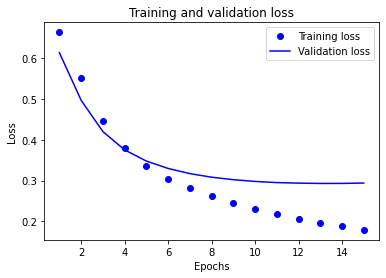

In [24]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

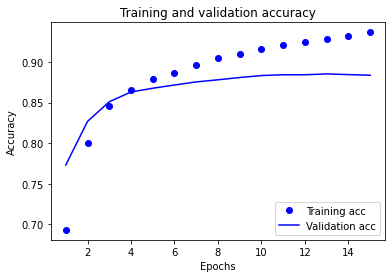

In [25]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()